# MovieLens 100k Collaborative Genre Tagging
**To do**:
  - try out [this implementation](https://www.onceupondata.com/2019/02/10/nn-collaborative-filtering/) of baseline features. 
  - create object classes for models
  - implement TF 2.0 data classes
  - [paperswithcode link](https://paperswithcode.com/sota/collaborative-filtering-on-movielens-100k)
  - [ML 100k state of the art paper](https://arxiv.org/pdf/1706.02263v2.pdf) (RMSE=0.905): details their evaluation method
  
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/James-Leslie/deep-collaborative-filtering/blob/master/tf-movielens100k.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

%matplotlib inline

## Load rating data

In [2]:
# path = 'https://raw.githubusercontent.com/James-Leslie/deep-collaborative-filtering/master/data/ml-100k/'  # access from anywhere
path = 'data/ml-100k/'  # if the files are local
df = pd.read_csv(path+'ratings.csv', usecols=['userId','movieId','rating'])

In [3]:
df.head()

,userId,movieId,rating
0,0,0,3
1,1,1,3
2,2,2,1
3,3,3,2
4,4,4,1


In [4]:
df.shape

(100000, 3)

In [5]:
print('Number of users:', df.userId.nunique())
print('Number of items:', df.movieId.nunique())
print("Min item rating:", df.rating.min())
print("Max item rating:", df.rating.max())
print("Mean item rating:", df.rating.mean())

Number of users: 943
Number of items: 1682
Min item rating: 1
Max item rating: 5
Mean item rating: 3.52986


## Load movie metadata
  - remove 10% as holdout test set

In [6]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,releaseDate,link,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,24,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,147,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,233,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,47,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,75,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
movies, movies_holdout = train_test_split(movies, test_size=.1, random_state=42)

---
# Create baseline features
For each user, calculate average user bias - the average difference between the user's rating and the movie's average rating:

$$b_{u} = \dfrac{\sum_{j=1}^{n_u} (r_{uj} - \mu_i)}{n_u}$$

For each item, calculate the difference between its average rating and the average rating of all movies:

$$b_{i} = \dfrac{\sum_{k=1}^{n_i} (r_{ki})}{n_i} - \mu$$

Then, for each interaction, calculate the combined bias:

$$b_{ui} = \dfrac{b_u + b_i}{2}$$

In [9]:
from CGT import get_baseline
?get_baseline

Signature: get_baseline(df, train_index, test_index)
Docstring:
Calculate baseline features from an explicit ratings dataset. Receives a dataframe
and returns train and test splits with added bias column and mean rating value.
User and item biases are calculated as average difference from global mean rating.
Baseline factors are only calculated from training observations, with users or
items that do not appear in train receiving the global average as default.

Args:
    df          : explicit ratings dataframe with columns userId, movieId and rating
    train_index : train index splits taken from KFold.splits()
    test_index  : test index splits taken from KFold.splits()
    
Returns:
    train, test : train/test splits of df, with added bias column
    global_mean : average rating of all training observations
File:      c:\users\jleslie\documents\deep-collaborative-filtering\cgt.py
Type:      function


---
# CGT model
**To do**:
  - Can we avoid re-training rating model on CV fold?
  - Create a grid search function / class

In [10]:
from CGT import compile_genre_model
?compile_genre_model

Signature:
compile_genre_model(
    n_items,
    n_users,
    min_rating,
    max_rating,
    mean_rating,
    n_latent,
    n_hidden_1,
    n_hidden_2,
    activation='relu',
    dropout_1=0.2,
    dropout_2=0.2,
    random_seed=42,
)
Docstring: <no docstring>
File:      c:\users\jleslie\documents\deep-collaborative-filtering\cgt.py
Type:      function


---
## Grid search
**To do**: try using [tqdm](https://github.com/tqdm/tqdm) notebook bars

```bash
# bash
pip install --upgrade ipywidgets 
jupyter nbextension enable --py widgetsnbextension
jupyter labextension install @jupyter-widgets/jupyterlab-manager
```

```python
# python
from tqdm.notebook import trange, tqdm
from time import sleep

for i in trange(3, desc='1st loop'):
    for j in tqdm(range(100), desc='2nd loop'):
        sleep(0.01)
```

## 1. Number of latent factors and hidden nodes

In [11]:
from sklearn.model_selection import KFold

In [12]:
# hyper parameters
HP_N_FACTORS = [50, 100, 200]
HP_N_HIDDEN_1 = [50, 100]
HP_N_HIDDEN_2 = [50, 100]

In [13]:
# dataframe to store results of grid search
grid_results = []
searches = 1

n_models = len(HP_N_FACTORS) * len(HP_N_HIDDEN_1) * len(HP_N_HIDDEN_2)

print(f'Fitting total of {n_models} models\n')

for N_FACTORS in HP_N_FACTORS:
    for N_HIDDEN_1 in HP_N_HIDDEN_1:
        for N_HIDDEN_2 in HP_N_HIDDEN_2:
            
            print(f'Fitting CGT model #{searches} with {N_FACTORS}: {N_HIDDEN_1} | {N_HIDDEN_2} architecture')
            searches += 1
            
            # Create 5 CV folds
            kf = KFold(n_splits=5, random_state=42)
            
            # initialise loss and epoch count
            total_loss = 0
            total_acc = 0
            count = 1
            min_epochs = 10
            
            # do CV split and compute baseline predictors each time
            for train_index, test_index in kf.split(movies):
                
                # get baseline rating predictors for full dataset
                train, _, _ = get_baseline(df, df.index, df.index)

                # compile both models with search hparams
                model1, model2 = compile_genre_model(
                    n_items=df.movieId.nunique(),
                    n_users=df.userId.nunique(),
                    min_rating=df.rating.min(),
                    max_rating=df.rating.max(),
                    mean_rating=df.rating.mean(),
                    n_latent=N_FACTORS, 
                    n_hidden_1=N_HIDDEN_1,
                    n_hidden_2=N_HIDDEN_2
                )

                # train rating model on all data
                ratings = model1.fit(
                    x=[train.userId.values, train.movieId.values, train.bias.values],
                    y=train.rating.values, 
                    batch_size=512,
                    epochs=7,
                    verbose=0,
                    validation_split=.2
                )
                
                # train genre model on 5 CV folds
                train = movies.iloc[train_index]
                test = movies.iloc[test_index]
                
                # train model on current fold
                result = model2.fit(
                    train.movieId.values, train.Drama.values,
                    batch_size=64, 
                    epochs=5,
                    verbose=0,
                    validation_data=(test.movieId.values, test.Drama.values))
                
                # get loss from this fold
                fold_loss = result.history['val_loss'][-1]
                total_loss += fold_loss
                fold_acc = result.history['val_accuracy'][-1]
                total_acc += fold_acc
                
                count += 1
                
                del model1, model2
            
            # calculate average holdout loss across all CV folds
            avg_loss = total_loss / 5
            avg_acc = total_acc / 5
            print(f'_____________________________________CV avg val loss={avg_loss:.4f}')
            print(f'_____________________________________CV avg val acc={avg_acc:.4f}')
            
            grid_results.append({'n_factors':N_FACTORS,
                                 'n_hidden_1':N_HIDDEN_1,
                                 'n_hidden_2':N_HIDDEN_2,
                                 'val_loss':avg_loss,
                                 'val_acc':avg_acc,
                                 'train_loss_hist':result.history['loss'],
                                 'val_loss_hist':result.history['val_loss'],
                                 'train_acc_hist':result.history['accuracy'],
                                 'val_acc_hist':result.history['val_accuracy']})
            
            print()
#             break
#         break
#     break
    
col_order = grid_results[0].keys()

# save results to data frame
grid_results = pd.DataFrame(grid_results)
# reorder columns
grid_results = grid_results[col_order]

Fitting total of 12 models

Fitting CGT model #1 with 50: 50 | 50 architecture
_____________________________________CV avg val loss=0.6485
_____________________________________CV avg val acc=0.6127

Fitting CGT model #2 with 50: 50 | 100 architecture
_____________________________________CV avg val loss=0.6419
_____________________________________CV avg val acc=0.6167

Fitting CGT model #3 with 50: 100 | 50 architecture
_____________________________________CV avg val loss=0.6490
_____________________________________CV avg val acc=0.6114

Fitting CGT model #4 with 50: 100 | 100 architecture
_____________________________________CV avg val loss=0.6437
_____________________________________CV avg val acc=0.6081

Fitting CGT model #5 with 100: 50 | 50 architecture
_____________________________________CV avg val loss=0.6441
_____________________________________CV avg val acc=0.6173

Fitting CGT model #6 with 100: 50 | 100 architecture
_____________________________________CV avg val loss=0.6394

In [14]:
# get best 10 models
grid_results = grid_results.sort_values('val_loss')
grid_results.to_csv(path+'grid_results.csv', index=False)

grid_results.head(10)

,n_factors,n_hidden_1,n_hidden_2,val_loss,val_acc,train_loss_hist,val_loss_hist,train_acc_hist,val_acc_hist
11,200,100,100,0.634391,0.631196,"[0.6799719030949618, 0.6538735683253735, 0.639...","[0.656111725118776, 0.6273785146656415, 0.6142...","[0.5697771, 0.6374897, 0.6284063, 0.6366639, 0...","[0.6589404, 0.6754967, 0.6821192, 0.6721854, 0..."
10,200,100,50,0.636529,0.625242,"[0.68565977116836, 0.6643060801641494, 0.64932...","[0.6667345967513836, 0.641903289106508, 0.6251...","[0.5590421, 0.62923205, 0.63336086, 0.6407927,...","[0.66225165, 0.6754967, 0.6721854, 0.66887414,..."
7,100,100,100,0.639080,0.627887,"[0.6835945834314203, 0.6629803921445946, 0.649...","[0.6642093638710628, 0.6366910997605482, 0.619...","[0.5780347, 0.6151941, 0.61849713, 0.61849713,...","[0.6456954, 0.6423841, 0.63907284, 0.6490066, ..."
5,100,50,100,0.639409,0.623928,"[0.6783501644158146, 0.6587709308064348, 0.647...","[0.6579029556141783, 0.6336303763831688, 0.620...","[0.5871181, 0.60611063, 0.611891, 0.611891, 0....","[0.6490066, 0.6456954, 0.63907284, 0.6589404, ..."
9,200,50,100,0.640560,0.628545,"[0.6764455629123527, 0.6524980644073297, 0.641...","[0.6519363262005989, 0.6260997155644247, 0.616...","[0.597853, 0.6275805, 0.63170934, 0.6366639, 0...","[0.6490066, 0.6490066, 0.6456954, 0.6490066, 0..."
8,200,50,50,0.641612,0.625242,"[0.6855154594146545, 0.6660685414720625, 0.653...","[0.6675781394472186, 0.643778209259968, 0.6272...","[0.5639967, 0.6234517, 0.6209744, 0.63336086, ...","[0.6589404, 0.6456954, 0.6423841, 0.6490066, 0..."
1,50,50,100,0.641890,0.616661,"[0.6801429476548974, 0.6651297323867175, 0.654...","[0.6638502991752119, 0.6431749245978349, 0.628...","[0.61271673, 0.6085879, 0.60611063, 0.61271673...","[0.6490066, 0.66887414, 0.6754967, 0.6821192, ..."
6,100,100,50,0.643089,0.621940,"[0.6903239869067336, 0.6738445346361345, 0.660...","[0.6742422395194603, 0.652297492453594, 0.6355...","[0.52683735, 0.5937242, 0.6094137, 0.6135425, ...","[0.6423841, 0.63245034, 0.6423841, 0.6423841, ..."
3,50,100,100,0.643686,0.608061,"[0.6862890340886167, 0.6713248806783328, 0.658...","[0.6730248647809818, 0.6515781997844873, 0.634...","[0.57060283, 0.6028076, 0.6003303, 0.60776216,...","[0.6092715, 0.6357616, 0.62913907, 0.63245034,..."
4,100,50,50,0.644122,0.617313,"[0.6905663848710789, 0.6745668287911167, 0.662...","[0.6800712856235883, 0.6588892486711212, 0.641...","[0.5342692, 0.59207267, 0.60776216, 0.6094137,...","[0.6357616, 0.62913907, 0.62913907, 0.63907284..."


In [15]:
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (16,9),
            'font.family': 'serif'})

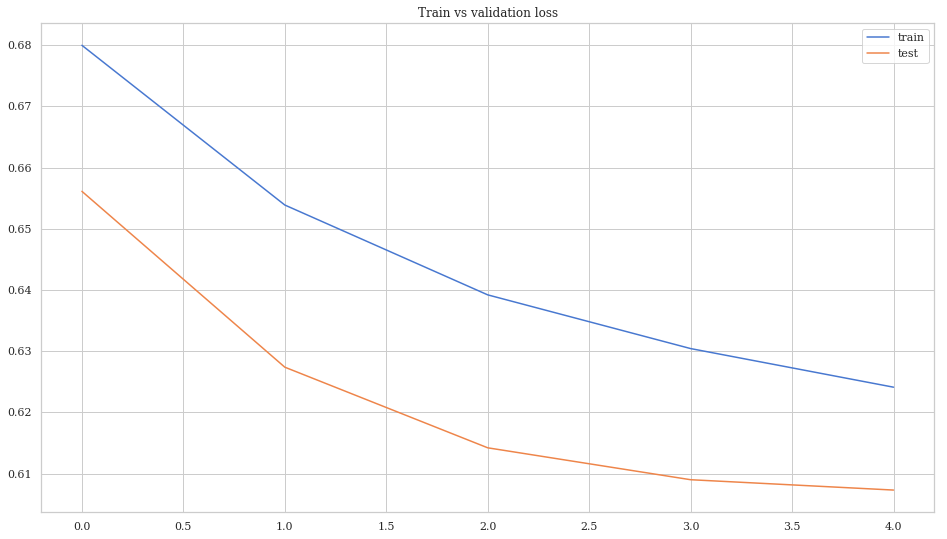

In [16]:
# plot training curve of best model
plt.plot(grid_results.train_loss_hist.values[0], label='train')
plt.plot(grid_results.val_loss_hist.values[0], label='test')
plt.title('Train vs validation loss')
plt.legend()
plt.show()

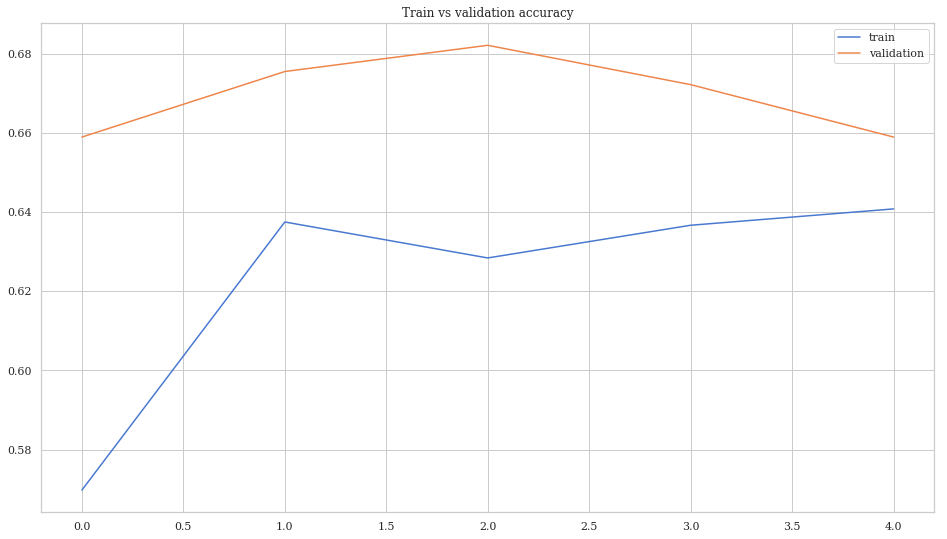

In [17]:
# train vs test accuracy
plt.plot(grid_results.train_acc_hist.values[0], label='train')
plt.plot(grid_results.val_acc_hist.values[0], label='validation')
plt.title('Train vs validation accuracy')
plt.legend()
plt.show()

In [18]:
best_rating_hparams = grid_results.iloc[0,:][['n_factors' ,'n_hidden_1', 'n_hidden_2']]
best_rating_hparams

n_factors     200
n_hidden_1    100
n_hidden_2    100
Name: 11, dtype: object

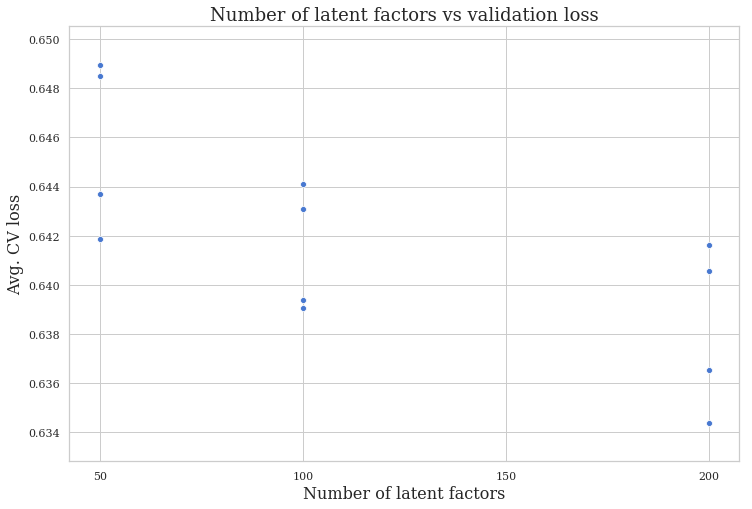

In [19]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='n_factors',
                y='val_loss',
#                 hue='n_hidden_2',
#                 size='n_hidden_2',
#                 palette='Set3',
                data=grid_results)

plt.title('Number of latent factors vs validation loss', fontsize=18)
plt.xlabel('Number of latent factors', fontsize=16)
plt.xticks([50,100,150,200])
plt.ylabel('Avg. CV loss', fontsize=16)
plt.savefig('figures/5_ml100k-latent-factors.pdf', bbox_inches='tight')
# plt.legend(title='Hidden layer in genre model')
plt.show()

## 2. Number of epochs

In [20]:
# hyper parameters
HP_EPOCH_1 = [5, 6, 7]
HP_EPOCH_2 = [3, 4, 5]

In [21]:
# dataframe to store results of grid search
grid_results_2 = []
searches = 1

n_models = len(HP_EPOCH_1) * len(HP_EPOCH_2)

print(f'Fitting total of {n_models} models\n')

for EPOCH_1 in HP_EPOCH_1:
    for EPOCH_2 in HP_EPOCH_2:

        print(f'Fitting CGT model #{searches} for {EPOCH_1} epochs and {EPOCH_2} epochs')
        searches += 1

        # Create 5 CV folds
        kf = KFold(n_splits=5, random_state=42)

        # initialise loss and epoch count
        total_loss = 0
        total_acc = 0
        count = 1
        min_epochs = 10

        # do CV split and compute baseline predictors each time
        for train_index, test_index in kf.split(movies):

            # get baseline rating predictors for full dataset
            train, _, _ = get_baseline(df, df.index, df.index)

            # compile both models with search hparams
            model1, model2 = compile_genre_model(
                n_items=df.movieId.nunique(),
                n_users=df.userId.nunique(),
                min_rating=df.rating.min(),
                max_rating=df.rating.max(),
                mean_rating=df.rating.mean(),
                n_latent=best_rating_hparams.n_factors, 
                n_hidden_1=best_rating_hparams.n_hidden_1,
                n_hidden_2=best_rating_hparams.n_hidden_2
            )

            # train rating model on all data
            ratings = model1.fit(
                x=[train.userId.values, train.movieId.values, train.bias.values],
                y=train.rating.values, 
                batch_size=512,
                epochs=EPOCH_1,
                verbose=0,
                validation_split=.2
            )

            # train genre model on 5 CV folds
            train = movies.iloc[train_index]
            test = movies.iloc[test_index]

            # train model on current fold
            result = model2.fit(
                train.movieId.values, train.Drama.values,
                batch_size=64, 
                epochs=EPOCH_2,
                verbose=0,
                validation_data=(test.movieId.values, test.Drama.values))

            # get loss from this fold
            fold_loss = result.history['val_loss'][-1]
            total_loss += fold_loss
            fold_acc = result.history['val_accuracy'][-1]
            total_acc += fold_acc

            count += 1

            del model1, model2

        # calculate average holdout loss across all CV folds
        avg_loss = total_loss / 5
        avg_acc = total_acc / 5
        print(f'_____________________________________CV avg val loss={avg_loss:.4f}')
        print(f'_____________________________________CV avg val acc={avg_acc:.4f}')

        grid_results_2.append({'epoch_1':EPOCH_1,
                               'epoch_2':EPOCH_2,
                               'val_loss':avg_loss,
                               'val_acc':avg_acc,
                               'train_loss_hist':result.history['loss'],
                               'val_loss_hist':result.history['val_loss'],
                               'train_acc_hist':result.history['accuracy'],
                               'val_acc_hist':result.history['val_accuracy']})

        print()
#             break
#         break
    
col_order = grid_results_2[0].keys()

# save results to data frame
grid_results_2 = pd.DataFrame(grid_results_2)
# reorder columns
grid_results_2 = grid_results_2[col_order]

Fitting total of 9 models

Fitting CGT model #1 for 5 epochs and 3 epochs
_____________________________________CV avg val loss=0.6403
_____________________________________CV avg val acc=0.6246

Fitting CGT model #2 for 5 epochs and 4 epochs
_____________________________________CV avg val loss=0.6387
_____________________________________CV avg val acc=0.6285

Fitting CGT model #3 for 5 epochs and 5 epochs
_____________________________________CV avg val loss=0.6376
_____________________________________CV avg val acc=0.6272

Fitting CGT model #4 for 6 epochs and 3 epochs
_____________________________________CV avg val loss=0.6385
_____________________________________CV avg val acc=0.6338

Fitting CGT model #5 for 6 epochs and 4 epochs
_____________________________________CV avg val loss=0.6366
_____________________________________CV avg val acc=0.6332

Fitting CGT model #6 for 6 epochs and 5 epochs
_____________________________________CV avg val loss=0.6353
_______________________________

In [22]:
# get best 5 models
grid_results_2 = grid_results_2.sort_values('val_loss')
grid_results_2.to_csv(path+'grid_results_2.csv', index=False)

grid_results_2.head(5)

,epoch_1,epoch_2,val_loss,val_acc,train_loss_hist,val_loss_hist,train_acc_hist,val_acc_hist
8,7,5,0.634391,0.631196,"[0.6799719030949618, 0.6538735683253735, 0.639...","[0.656111725118776, 0.6273785146656415, 0.6142...","[0.5697771, 0.6374897, 0.6284063, 0.6366639, 0...","[0.6589404, 0.6754967, 0.6821192, 0.6721854, 0..."
5,6,5,0.635266,0.631856,"[0.6800451562190036, 0.65382656068668, 0.63959...","[0.6567415614791264, 0.6274575721349148, 0.614...","[0.5895954, 0.6374897, 0.6350124, 0.63996696, ...","[0.65562916, 0.6655629, 0.6655629, 0.66887414,..."
7,7,4,0.636045,0.631202,"[0.6799719030949618, 0.6538735683253735, 0.639...","[0.656111725118776, 0.6273785146656415, 0.6142...","[0.5697771, 0.6374897, 0.6284063, 0.6366639]","[0.6589404, 0.6754967, 0.6821192, 0.6721854]"
4,6,4,0.636588,0.633185,"[0.6800451562190036, 0.65382656068668, 0.63959...","[0.6567415614791264, 0.6274575721349148, 0.614...","[0.5895954, 0.6374897, 0.6350124, 0.63996696]","[0.65562916, 0.6655629, 0.6655629, 0.66887414]"
2,5,5,0.637616,0.627218,"[0.6805931951859882, 0.6553502387000351, 0.641...","[0.6575600157510366, 0.6289482321960247, 0.615...","[0.58546656, 0.62510324, 0.63831544, 0.6383154...","[0.6357616, 0.65562916, 0.6589404, 0.6655629, ..."


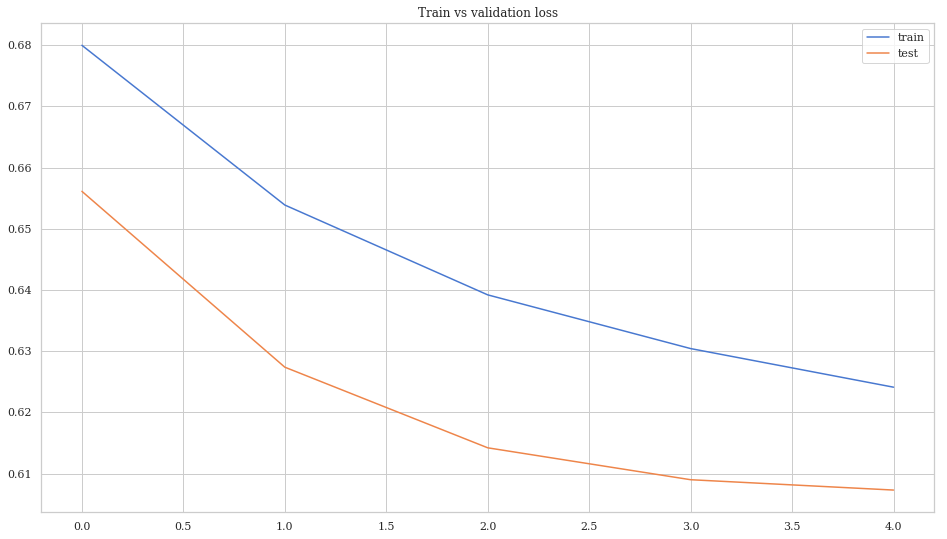

In [23]:
# plot training curve of best model
plt.plot(grid_results_2.train_loss_hist.values[0], label='train')
plt.plot(grid_results_2.val_loss_hist.values[0], label='test')
plt.title('Train vs validation loss')
plt.legend()
plt.show()

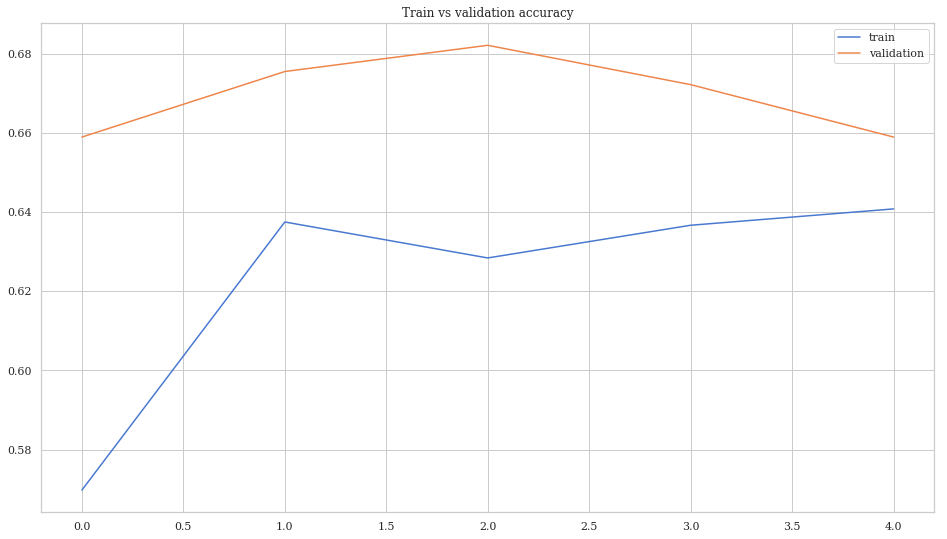

In [24]:
# train vs test accuracy
plt.plot(grid_results_2.train_acc_hist.values[0], label='train')
plt.plot(grid_results_2.val_acc_hist.values[0], label='validation')
plt.title('Train vs validation accuracy')
plt.legend()
plt.show()

In [25]:
best_rating_hparams = pd.concat((best_rating_hparams, grid_results_2.iloc[0,:][['epoch_1', 'epoch_2']]))
best_rating_hparams

n_factors     200
n_hidden_1    100
n_hidden_2    100
epoch_1         7
epoch_2         5
dtype: object

## 3. Dropout rates

In [26]:
# hyper parameters
HP_DROPOUT_1 = [.15, .2, .25]
HP_DROPOUT_2 = [.15, .2, .25]

In [27]:
# dataframe to store results of grid search
grid_results_3 = []
searches = 1

n_models = len(HP_DROPOUT_1) * len(HP_DROPOUT_2)

print(f'Fitting total of {n_models} models\n')

for DROPOUT_1 in HP_DROPOUT_1:
    for DROPOUT_2 in HP_DROPOUT_2:

        print(f'Fitting CGT model #{searches} with dr1: {DROPOUT_1} | dr2: {DROPOUT_2}')
        searches += 1

        # Create 5 CV folds
        kf = KFold(n_splits=5, random_state=42)

        # initialise loss and epoch count
        total_loss = 0
        total_acc = 0
        count = 1
        min_epochs = 10

        # do CV split and compute baseline predictors each time
        for train_index, test_index in kf.split(movies):

            # get baseline rating predictors for full dataset
            train, _, _ = get_baseline(df, df.index, df.index)

            # compile both models with search hparams
            model1, model2 = compile_genre_model(
                n_items=df.movieId.nunique(),
                n_users=df.userId.nunique(),
                min_rating=df.rating.min(),
                max_rating=df.rating.max(),
                mean_rating=df.rating.mean(),
                n_latent=best_rating_hparams.n_factors, 
                n_hidden_1=best_rating_hparams.n_hidden_1,
                n_hidden_2=best_rating_hparams.n_hidden_2,
                dropout_1=DROPOUT_1,
                dropout_2=DROPOUT_2
            )

            # train rating model on all data
            ratings = model1.fit(
                x=[train.userId.values, train.movieId.values, train.bias.values],
                y=train.rating.values, 
                batch_size=512,
                epochs=best_rating_hparams.epoch_1,
                verbose=0,
                validation_split=.2
            )

            # train genre model on 5 CV folds
            train = movies.iloc[train_index]
            test = movies.iloc[test_index]

            # train model on current fold
            result = model2.fit(
                train.movieId.values, train.Drama.values,
                batch_size=64, 
                epochs=best_rating_hparams.epoch_2,
                verbose=0,
                validation_data=(test.movieId.values, test.Drama.values))

            # get loss from this fold
            fold_loss = result.history['val_loss'][-1]
            total_loss += fold_loss
            fold_acc = result.history['val_accuracy'][-1]
            total_acc += fold_acc
            count += 1

            del model1, model2

        # calculate average holdout loss across all CV folds
        avg_loss = total_loss / 5
        avg_acc = total_acc / 5
        print(f'_____________________________________CV avg val loss={avg_loss:.4f}')
        print(f'_____________________________________CV avg val acc={avg_acc:.4f}')

        grid_results_3.append({'dropout_1':DROPOUT_1,
                               'dropout_2':DROPOUT_2,
                               'val_loss':avg_loss,
                               'val_acc':avg_acc,
                               'train_loss_hist':result.history['loss'],
                               'val_loss_hist':result.history['val_loss'],
                               'train_acc_hist':result.history['accuracy'],
                               'val_acc_hist':result.history['val_accuracy']})

        print()
#             break
#         break
    
col_order = grid_results_3[0].keys()

# save results to data frame
grid_results_3 = pd.DataFrame(grid_results_3)
# reorder columns
grid_results_3 = grid_results_3[col_order]

Fitting total of 9 models

Fitting CGT model #1 with dr1: 0.15 | dr2: 0.15
_____________________________________CV avg val loss=0.6355
_____________________________________CV avg val acc=0.6286

Fitting CGT model #2 with dr1: 0.15 | dr2: 0.2
_____________________________________CV avg val loss=0.6356
_____________________________________CV avg val acc=0.6292

Fitting CGT model #3 with dr1: 0.15 | dr2: 0.25
_____________________________________CV avg val loss=0.6357
_____________________________________CV avg val acc=0.6279

Fitting CGT model #4 with dr1: 0.2 | dr2: 0.15
_____________________________________CV avg val loss=0.6343
_____________________________________CV avg val acc=0.6305

Fitting CGT model #5 with dr1: 0.2 | dr2: 0.2
_____________________________________CV avg val loss=0.6344
_____________________________________CV avg val acc=0.6312

Fitting CGT model #6 with dr1: 0.2 | dr2: 0.25
_____________________________________CV avg val loss=0.6345
______________________________

In [28]:
# get best 5 models
grid_results_3 = grid_results_3.sort_values('val_loss')
grid_results_3.to_csv(path+'grid_results_3.csv', index=False)

grid_results_3.head(5)

,dropout_1,dropout_2,val_loss,val_acc,train_loss_hist,val_loss_hist,train_acc_hist,val_acc_hist
6,0.25,0.15,0.633422,0.629882,"[0.6796723707070732, 0.652869732295256, 0.6377...","[0.6552467788292082, 0.6264953396178239, 0.613...","[0.5871181, 0.6284063, 0.6308836, 0.6325351, 0...","[0.6423841, 0.6490066, 0.6456954, 0.6655629, 0..."
7,0.25,0.20,0.633550,0.633189,"[0.6799026882717375, 0.6535110604064116, 0.638...","[0.6559610793132655, 0.6274979532949182, 0.614...","[0.5821635, 0.63336086, 0.6308836, 0.6325351, ...","[0.6456954, 0.6456954, 0.6456954, 0.66225165, ..."
8,0.25,0.25,0.633696,0.631865,"[0.6801554609880676, 0.6538513908201166, 0.638...","[0.6566360577052792, 0.6283979159317269, 0.614...","[0.5862923, 0.6284063, 0.6275805, 0.63170934, ...","[0.6456954, 0.6456954, 0.6490066, 0.6589404, 0..."
3,0.20,0.15,0.634265,0.630534,"[0.6796614232386172, 0.653274898534959, 0.6384...","[0.6554121580344952, 0.6264005990217854, 0.613...","[0.5780347, 0.6391412, 0.6325351, 0.6407927, 0...","[0.6589404, 0.6721854, 0.6821192, 0.6754967, 0..."
4,0.20,0.20,0.634391,0.631196,"[0.6799719030949618, 0.6538735683253735, 0.639...","[0.656111725118776, 0.6273785146656415, 0.6142...","[0.5697771, 0.6374897, 0.6284063, 0.6366639, 0...","[0.6589404, 0.6754967, 0.6821192, 0.6721854, 0..."


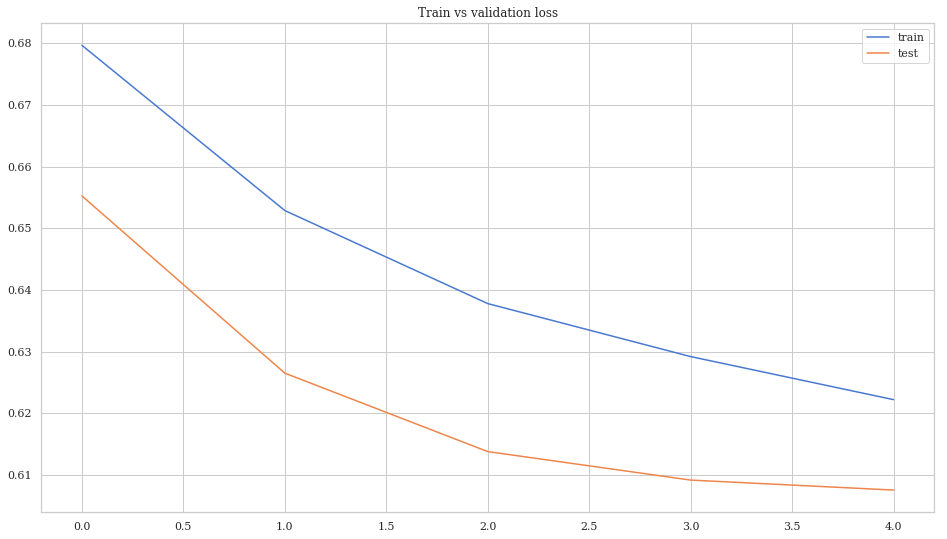

In [29]:
# plot training curve of best model
plt.plot(grid_results_3.train_loss_hist.values[0], label='train')
plt.plot(grid_results_3.val_loss_hist.values[0], label='test')
plt.title('Train vs validation loss')
plt.legend()
plt.show()

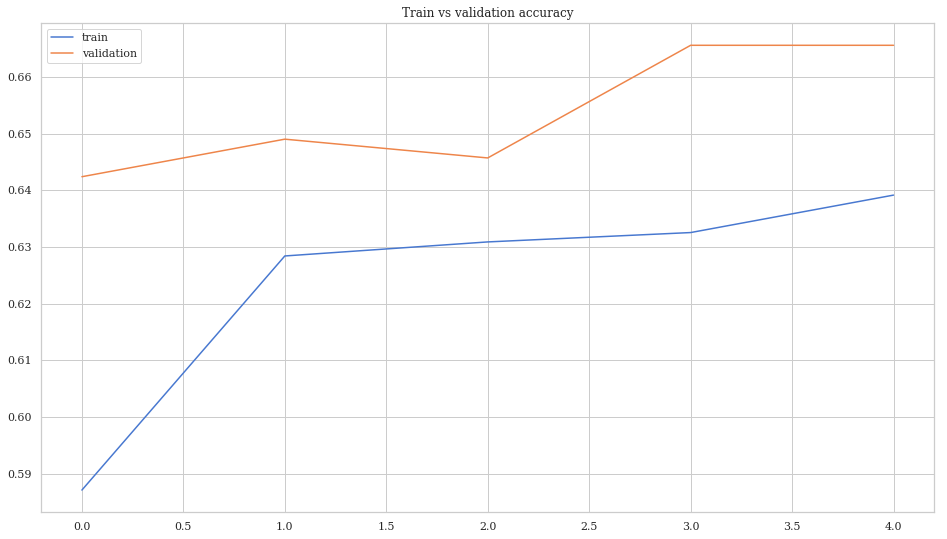

In [30]:
# train vs test accuracy
plt.plot(grid_results_3.train_acc_hist.values[0], label='train')
plt.plot(grid_results_3.val_acc_hist.values[0], label='validation')
plt.title('Train vs validation accuracy')
plt.legend()
plt.show()

In [31]:
best_rating_hparams = pd.concat((best_rating_hparams, grid_results_3.iloc[0,:][['dropout_1', 'dropout_2']]))
best_rating_hparams

n_factors      200
n_hidden_1     100
n_hidden_2     100
epoch_1          7
epoch_2          5
dropout_1     0.25
dropout_2     0.15
dtype: object

## 4. Activation function

In [32]:
# hyper parameters
HP_ACTIVATION = [None, 'relu', 'selu', 'softplus', 'tanh']

In [33]:
# dataframe to store results of grid search
grid_results_4 = []
searches = 1

n_models = len(HP_ACTIVATION)

print(f'Fitting total of {n_models} models\n')

for ACTIVATION in HP_ACTIVATION:

    print(f'Fitting CGT model #{searches} with {ACTIVATION}')
    searches += 1

    # Create 5 CV folds
    kf = KFold(n_splits=5, random_state=42)

    # initialise loss and epoch count
    total_loss = 0
    total_acc = 0
    count = 1
    min_epochs = 10

    # do CV split and compute baseline predictors each time
    for train_index, test_index in kf.split(movies):

        # get baseline rating predictors for full dataset
        train, _, _ = get_baseline(df, df.index, df.index)

        # compile both models with search hparams
        model1, model2 = compile_genre_model(
            n_items=df.movieId.nunique(),
            n_users=df.userId.nunique(),
            min_rating=df.rating.min(),
            max_rating=df.rating.max(),
            mean_rating=df.rating.mean(),
            n_latent=best_rating_hparams.n_factors, 
            n_hidden_1=best_rating_hparams.n_hidden_1,
            n_hidden_2=best_rating_hparams.n_hidden_2,
            dropout_1=best_rating_hparams.dropout_1,
            dropout_2=best_rating_hparams.dropout_2,
            activation=ACTIVATION
        )

        # train rating model on all data
        ratings = model1.fit(
            x=[train.userId.values, train.movieId.values, train.bias.values],
            y=train.rating.values, 
            batch_size=512,
            epochs=best_rating_hparams.epoch_1,
            verbose=0,
            validation_split=.2
        )

        # train genre model on 5 CV folds
        train = movies.iloc[train_index]
        test = movies.iloc[test_index]

        # train model on current fold
        result = model2.fit(
            train.movieId.values, train.Drama.values,
            batch_size=64, 
            epochs=best_rating_hparams.epoch_2,
            verbose=0,
            validation_data=(test.movieId.values, test.Drama.values))

        # get loss from this fold
        fold_loss = result.history['val_loss'][-1]
        total_loss += fold_loss
        fold_acc = result.history['val_accuracy'][-1]
        total_acc += fold_acc

        count += 1

        del model1, model2

    # calculate average holdout loss across all CV folds
    avg_loss = total_loss / 5
    avg_acc = total_acc / 5
    print(f'_____________________________________CV avg val loss={avg_loss:.4f}')
    print(f'_____________________________________CV avg val acc={avg_acc:.4f}')

    grid_results_4.append({'activation':ACTIVATION,
                           'val_loss':avg_loss,
                           'val_acc':avg_acc,
                           'train_loss_hist':result.history['loss'],
                           'val_loss_hist':result.history['val_loss'],
                           'train_acc_hist':result.history['accuracy'],
                           'val_acc_hist':result.history['val_accuracy']})

    print()
    
col_order = grid_results_4[0].keys()

# save results to data frame
grid_results_4 = pd.DataFrame(grid_results_4)
# reorder columns
grid_results_4 = grid_results_4[col_order]

Fitting total of 5 models

Fitting CGT model #1 with None
_____________________________________CV avg val loss=0.6500
_____________________________________CV avg val acc=0.5942

Fitting CGT model #2 with relu
_____________________________________CV avg val loss=0.6337
_____________________________________CV avg val acc=0.6319

Fitting CGT model #3 with selu
_____________________________________CV avg val loss=0.6467
_____________________________________CV avg val acc=0.6067

Fitting CGT model #4 with softplus
_____________________________________CV avg val loss=0.6461
_____________________________________CV avg val acc=0.6081

Fitting CGT model #5 with tanh
_____________________________________CV avg val loss=0.6494
_____________________________________CV avg val acc=0.5995



In [34]:
# get best 5 models
grid_results_4 = grid_results_4.sort_values('val_loss')
grid_results_4.to_csv(path+'grid_results_4.csv', index=False)

grid_results_4.head(5)

,activation,val_loss,val_acc,train_loss_hist,val_loss_hist,train_acc_hist,val_acc_hist
1,relu,0.633696,0.631865,"[0.6801554609880676, 0.6538513908201166, 0.638...","[0.6566360577052792, 0.6283979159317269, 0.614...","[0.5862923, 0.6284063, 0.6275805, 0.63170934, ...","[0.6456954, 0.6456954, 0.6490066, 0.6589404, 0..."
3,softplus,0.646145,0.608072,"[0.6955813658719807, 0.6893263023614293, 0.682...","[0.6259774411750945, 0.6116850131394848, 0.609...","[0.57060283, 0.6003303, 0.5763832, 0.59454995,...","[0.6258278, 0.6456954, 0.63245034, 0.62913907,..."
2,selu,0.646698,0.606741,"[0.6618047464888122, 0.6471151272980857, 0.643...","[0.6111393938001418, 0.6080426056653458, 0.612...","[0.59702724, 0.6028076, 0.61023945, 0.61601985...","[0.65562916, 0.65562916, 0.63907284, 0.6490066..."
4,tanh,0.649363,0.599462,"[0.6654551675947711, 0.6516351148572271, 0.648...","[0.6179186445198311, 0.6120473576697293, 0.615...","[0.59042114, 0.60115606, 0.6094137, 0.60611063...","[0.63245034, 0.63907284, 0.6225166, 0.6258278,..."
0,None,0.649953,0.594177,"[0.6660229865427749, 0.6518491561702221, 0.649...","[0.6182262340918282, 0.6122737799259211, 0.616...","[0.5953757, 0.61023945, 0.6069364, 0.6094137, ...","[0.6258278, 0.6225166, 0.6258278, 0.6225166, 0..."


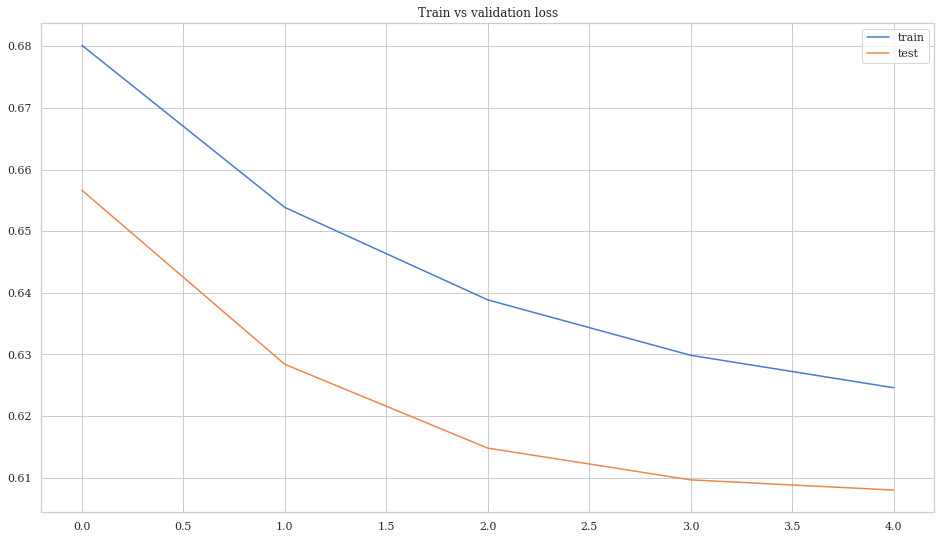

In [35]:
# plot training curve of best model
plt.plot(grid_results_4.train_loss_hist.values[0], label='train')
plt.plot(grid_results_4.val_loss_hist.values[0], label='test')
plt.title('Train vs validation loss')
plt.legend()
plt.show()

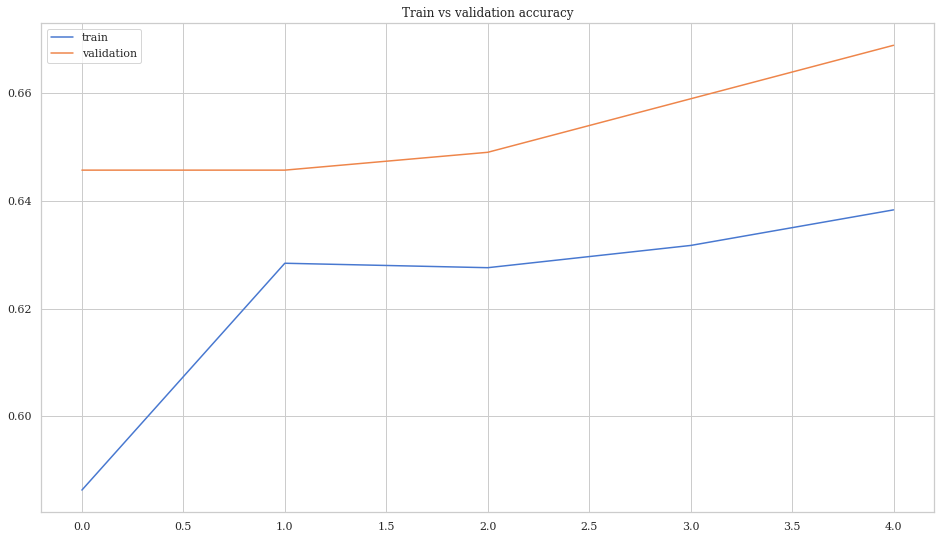

In [36]:
# train vs test accuracy
plt.plot(grid_results_4.train_acc_hist.values[0], label='train')
plt.plot(grid_results_4.val_acc_hist.values[0], label='validation')
plt.title('Train vs validation accuracy')
plt.legend()
plt.show()

In [37]:
best_rating_hparams = pd.concat((best_rating_hparams, grid_results_4.iloc[0,:][['activation']]))
best_rating_hparams

n_factors      200
n_hidden_1     100
n_hidden_2     100
epoch_1          7
epoch_2          5
dropout_1     0.25
dropout_2     0.15
activation    relu
dtype: object

# Classification report

In [38]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

### Re-train model on full dataset, with best hparams

In [39]:
# get baseline predictors for full dataset
train, _, _ = get_baseline(df, df.index, df.index)

# compile both models
model1, model2 = compile_genre_model(
    n_items=df.movieId.nunique(),
    n_users=df.userId.nunique(),
    min_rating=df.rating.min(),
    max_rating=df.rating.max(),
    mean_rating=df.rating.mean(),
    n_latent=best_rating_hparams.n_factors, 
    n_hidden_1=best_rating_hparams.n_hidden_1,
    n_hidden_2=best_rating_hparams.n_hidden_2,
    dropout_1=best_rating_hparams.dropout_1,
    dropout_2=best_rating_hparams.dropout_2,
    activation=best_rating_hparams.activation
)

# train rating model
ratings = model1.fit(
    x=[train.userId.values, train.movieId.values, train.bias.values],
    y=train.rating.values, 
    batch_size=256,
    epochs=8,
    verbose=1,
    validation_split=.2
)

# train genre model
genres = model2.fit(
    movies.movieId.values, movies.Drama.values,
    batch_size=64, 
    epochs=5,
    validation_split=.2)

Train on 80000 samples, validate on 20000 samples
Epoch 1/8
80000/80000 [==============================] - 4s 47us/sample - loss: 0.8935 - val_loss: 0.8592
Epoch 2/8
80000/80000 [==============================] - 3s 41us/sample - loss: 0.8369 - val_loss: 0.8459
Epoch 3/8
80000/80000 [==============================] - 3s 41us/sample - loss: 0.8045 - val_loss: 0.8371
Epoch 4/8
80000/80000 [==============================] - 3s 40us/sample - loss: 0.7660 - val_loss: 0.8346
Epoch 5/8
80000/80000 [==============================] - 4s 46us/sample - loss: 0.7206 - val_loss: 0.8347
Epoch 6/8
80000/80000 [==============================] - 4s 47us/sample - loss: 0.6774 - val_loss: 0.8440
Epoch 7/8
80000/80000 [==============================] - 4s 47us/sample - loss: 0.6362 - val_loss: 0.8563
Epoch 8/8
80000/80000 [==============================] - 4s 47us/sample - loss: 0.6005 - val_loss: 0.8648
Train on 1210 samples, validate on 303 samples
Epoch 1/5
1210/1210 [==============================] - 

### Evaluate on test set

In [40]:
X_test = movies_holdout.movieId.values
y_test = movies_holdout.Drama.values
y_score = pd.DataFrame(model2.predict(X_test))
y_pred = y_score.round().astype('int')

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.71      0.68        96
           1       0.58      0.52      0.55        73

    accuracy                           0.63       169
   macro avg       0.62      0.61      0.62       169
weighted avg       0.62      0.63      0.62       169



In [42]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,68,28
1,35,38


In [43]:
# add predictions as column
movies_holdout['prediction'] = y_pred.values
# save to csv
movies_holdout[['movieId', 'title', 'Drama', 'prediction']].to_csv(path+'holdout_predictions.csv', index=False)

In [44]:
X_train = movies.movieId.values
y_train = movies.Drama.values
train_score = pd.DataFrame(model2.predict(X_train))
train_pred = train_score.round().astype('int')

In [45]:
print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

           0       0.68      0.78      0.73       861
           1       0.64      0.52      0.57       652

    accuracy                           0.67      1513
   macro avg       0.66      0.65      0.65      1513
weighted avg       0.66      0.67      0.66      1513



In [46]:
pd.DataFrame(confusion_matrix(y_train, train_pred))

,0,1
0,671,190
1,316,336


In [47]:
# add predictions as column
movies['prediction'] = train_pred.values
# save to csv
movies[['movieId', 'title', 'Drama', 'prediction']].to_csv(path+'train_predictions.csv', index=False)

---
# Appendix A: multi-label genre model

In [48]:
from CGT import compile_multigenre_model

In [49]:
# get baseline predictors for full dataset
train, _, _ = get_baseline(df, df.index, df.index)

# compile both models
model1, model2 = compile_multigenre_model(
    n_items=df.movieId.nunique(),
    n_users=df.userId.nunique(),
    min_rating=df.rating.min(),
    max_rating=df.rating.max(),
    mean_rating=df.rating.mean(),
    n_genres=18,
    n_latent=best_rating_hparams.n_factors, 
    n_hidden_1=best_rating_hparams.n_hidden_1,
    n_hidden_2=best_rating_hparams.n_hidden_2,
    dropout_1=best_rating_hparams.dropout_1,
    dropout_2=best_rating_hparams.dropout_1
)

# train rating model
ratings = model1.fit(
    x=[train.userId.values, train.movieId.values, train.bias.values],
    y=train.rating.values, 
    batch_size=512,
    epochs=best_rating_hparams.epoch_1,
    verbose=1,
    validation_split=.2
)

Train on 80000 samples, validate on 20000 samples
Epoch 1/7
80000/80000 [==============================] - 3s 32us/sample - loss: 0.8971 - val_loss: 0.8622
Epoch 2/7
80000/80000 [==============================] - 2s 27us/sample - loss: 0.8412 - val_loss: 0.8507
Epoch 3/7
80000/80000 [==============================] - 2s 28us/sample - loss: 0.8152 - val_loss: 0.8409
Epoch 4/7
80000/80000 [==============================] - 2s 28us/sample - loss: 0.7878 - val_loss: 0.8364
Epoch 5/7
80000/80000 [==============================] - 2s 26us/sample - loss: 0.7523 - val_loss: 0.8271
Epoch 6/7
80000/80000 [==============================] - 2s 29us/sample - loss: 0.7115 - val_loss: 0.8336
Epoch 7/7
80000/80000 [==============================] - 2s 27us/sample - loss: 0.6706 - val_loss: 0.8425


In [50]:
# train genre model
genres = model2.fit(
    movies.movieId.values, movies.iloc[:,-19:-1].values,  # multi label
    batch_size=32, 
    epochs=best_rating_hparams.epoch_2,
    validation_split=.2)

Train on 1210 samples, validate on 303 samples
Epoch 1/5
1210/1210 [==============================] - 1s 602us/sample - loss: 0.6539 - accuracy: 0.7862 - AUC: 0.6397 - val_loss: 0.5983 - val_accuracy: 0.9037 - val_AUC: 0.7063
Epoch 2/5
1210/1210 [==============================] - 0s 139us/sample - loss: 0.5225 - accuracy: 0.9065 - AUC: 0.6829 - val_loss: 0.4328 - val_accuracy: 0.9059 - val_AUC: 0.7034
Epoch 3/5
1210/1210 [==============================] - 0s 138us/sample - loss: 0.3681 - accuracy: 0.9081 - AUC: 0.7053 - val_loss: 0.3180 - val_accuracy: 0.9061 - val_AUC: 0.7159
Epoch 4/5
1210/1210 [==============================] - 0s 142us/sample - loss: 0.2934 - accuracy: 0.9078 - AUC: 0.7429 - val_loss: 0.2824 - val_accuracy: 0.9065 - val_AUC: 0.7390
Epoch 5/5
1210/1210 [==============================] - 0s 142us/sample - loss: 0.2699 - accuracy: 0.9080 - AUC: 0.7702 - val_loss: 0.2716 - val_accuracy: 0.9069 - val_AUC: 0.7604


In [51]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

In [52]:
y_true = movies.iloc[:,-19:-1]
y_score = pd.DataFrame(model2.predict(movies.movieId.values), columns=y_true.columns)
y_pred = y_score.round().astype('int')

In [53]:
print(classification_report(y_true, y_pred, target_names=y_true.columns))

              precision    recall  f1-score   support

      Action       0.00      0.00      0.00       232
   Adventure       0.00      0.00      0.00       127
   Animation       0.00      0.00      0.00        37
  Children's       0.00      0.00      0.00       111
      Comedy       0.00      0.00      0.00       452
       Crime       0.00      0.00      0.00        96
 Documentary       0.00      0.00      0.00        44
       Drama       0.58      0.52      0.54       652
     Fantasy       0.00      0.00      0.00        20
   Film-Noir       0.00      0.00      0.00        22
      Horror       0.00      0.00      0.00        85
     Musical       0.00      0.00      0.00        47
     Mystery       0.00      0.00      0.00        56
     Romance       0.00      0.00      0.00       221
      Sci-Fi       0.00      0.00      0.00        91
    Thriller       0.00      0.00      0.00       225
         War       0.00      0.00      0.00        60
     Western       0.00    

C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined a